<a href="https://www.kaggle.com/code/davidphummel/computer-vision-is-it-a-dog-or-a-cat?scriptVersionId=194489875" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Computer Vision - Is it a dog or a cat?

This is the first Juypter notebook I created while reading chapter 1 of the Fastai course called [Practical Deep Learning](https://course.fast.ai).  Practical Deep Learning is a free course designed for people who have some coding experience and want to learn how to apply deep learning and maching learning to practical problems.  

I have found an understanding of how to program in Python is a requirement to complete this course along with a good understanding of the mathematical concepts.  I have spent some time refershing my memory of the NumPy package using the book [NumPy for Data Analysis](https://wesmckinney.com/book/numpy-basics) by Wes McKinney.  The NumPy pachage is used in the course to load and clean data along with building the models.  I have also found the need to refresh my memory of some of mathmatical concepts included in deep learning including gradient descent.  I really recommend the videos produced by [StatQuest](https://statquest.org/) on [gradient descent](https://youtu.be/sDv4f4s2SB8?si=SZjknb9ca-nl18ie) and others related to statistics and machine learning.  Josh Starmer created StatQuest to attempt to explain statistics to his former co-wokers.  His vidoes are simple easy to understand, and engaging! 

This Juypter notebook is a copy of Jeremy Howard's notebook called [Is it a bird? Creating a model from your own data](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data).  I modified Jeremy's notebook to determine if an image is a dog or a cat.  I have two portugese water dogs and 1 three legged cat, so I thought it would be fun to focus on them.  The objective of the notebook is to create and train a model to determine if an image is a dog or cat.

In [17]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    !pip install -Uqq fastai fastbook

The basic steps we'll take are:

1. Use DuckDuckGo to find images of dogs and cats on the Internet.
2. Fine-tune a pretrained neural network to recognise these two animals.
3. Try running this model on set of pictures and see if it works.

## Step 1: Download images of cats and dogs

Fastcore uses this flexibility to add to Python features inspired by other languages like multiple dispatch from Julia, mixins from Ruby, and currying, binding, and more from Haskell. It also adds some “missing features” and clean up some rough edges in the Python standard library, such as simplifying parallel processing, and bringing ideas from NumPy over to Python’s list type.

Let's start out by defining a function to search the Internet using DuckDuckGo for a term (e.g., "dog") and return a set of URLs to images of the term.

In [19]:
# Q: Why do I need to load fastcore.call?
from fastcore.all import *
from fastbook import search_images_ddg

def search_images(term, max=30):
  print(f"Searching for '{term}' using DuckDuckGo")
  return search_images_ddg(term, max_images=max)

Let's search for a dog, cat, and bird image and see what kind of result we get. I am downloading bird image because I want to see how the model reacts to a non-dog/non-cat image.  

We'll start by getting URLs using the search function.

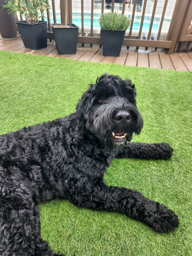

In [33]:
# Q: Why do I need to load fastai.vision.all?
from fastdownload import download_url
from fastai.vision.all import *

# Download the image of Max (see my-family-dogs dataset)
max_file = "../input/my-family-dogs/Max.jpg"
max_image = Image.open(max_file)
max_image.to_thumb(256, 256)

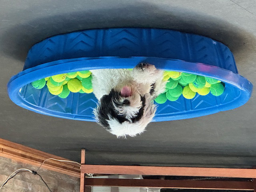

In [34]:
# Download the image of Lucy (see my-family-dogs dataset)
lucy_file = "../input/my-family-dogs/Lucy.jpg"
lucy_image = Image.open(lucy_file)
lucy_image.to_thumb(256, 256)

In [35]:
# Download and display a single dog image
dog_file = 'dog.jpg'
urls = search_images('dog photos', max=1)
download_url(urls[0], dog_file, show_progress=False)
print(urls[0])
dog_image = Image.open(dog_file)
dog_image.to_thumb(256,256)

Searching for 'dog photos' using DuckDuckGo
https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=1.00xw:0.669xh;0,0.190xh&resize=1200:*


UnidentifiedImageError: cannot identify image file 'dog.jpg'

Searching for 'cat photos' using DuckDuckGo


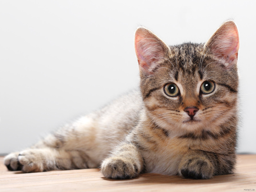

In [36]:
# Download and display a single cat image
cat_file = 'cat.jpg'
urls = search_images('cat photos', max=1)
download_url(urls[0], cat_file, show_progress=False)
cat_image = Image.open(cat_file)
cat_image.to_thumb(256,256)

Searching for 'bird photos' using DuckDuckGo


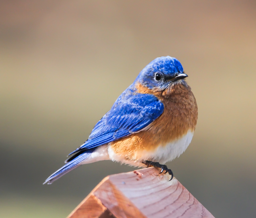

In [37]:
# Download and display a single bird image
bird_file = 'bird.jpg'
urls = search_images('bird photos', max=1)
download_url(urls[0], bird_file, show_progress=False)
bird_image = Image.open(bird_file)
bird_image.to_thumb(256,256)

The searches seem to be giving reasonable results, so let's grab a few examples dog and cat photos, and save each group of photos to a different folder.  We are also grabbing a set of images with different lighting conditions.

In [ ]:
from time import sleep

terms = 'dog','cat'
path = Path('animals')

for term in terms:
    dest = (path/term)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{term} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{term} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{term} shade photo'))
    sleep(10)
    resize_images(path/term, max_size=400, dest=path/term)

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [ ]:
# Find the images that can't be opened
failed = verify_images(get_image_files(path))

# Remove the image files which can't be openend.  The map function will execute the
# Path.unlink function over the failed images in the failed L object.
failed.map(Path.unlink)

print(f"{len(failed)} images were removed because they could not be verified.")

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

- ***blocks=(ImageBlock, CategoryBlock)*** - the input to our model are images and the outputs are catogries (in this case either a dog or a cat)

- ***get_items=get_image_files*** - to find all the inputs to the model we run the 'get_image_files' function which results a list of all the image files in the path.

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model

Let's see what our model thinks about that bird and forest we downloaded at the start:

In [ ]:
# Test the model using Max
#result,_,prob = learn.predict(PILImage.create(max_image))
result,_,prob = learn.predict(max_image)
print("Here is the image:")
im = Image.open(max_image)
im.to_thumb(256,256) 
display(im)
print(f"The model thinks this is a {result}.")
print(f"Probability it's a dog: {prob[1]:.4f}")
print(f"Probability it's a cat: {prob[0]:.4f}")

# Test the model using Lucy
#result,_,prob = learn.predict(PILImage.create(lucy_image))
result,_,prob = learn.predict(lucy_image)
print("Here is the image:")
im = Image.open(lucy_image)
im.to_thumb(256,256) 
display(im)
print(f"The model thinks this is a {result}.")
print(f"Probability it's a dog: {prob[1]:.4f}")
print(f"Probability it's a cat: {prob[0]:.4f}")

# Test the model using a dog image
#result,_,prob = learn.predict(PILImage.create(file))
result,_,prob = learn.predict(PILImage.create(dog_image))
print("Here is the image:")
im = Image.open(file)
im.to_thumb(256,256) 
display(im)
print(f"The model things this is a {result}.")
print(f"Probability it's a dog: {prob[1]:.4f}")
print(f"Probability it's a cat: {prob[0]:.4f}")

# Test the model using a cat image
#result,_,prob = learn.predict(PILImage.create(file))
result,_,prob = learn.predict(PILImage.create(cat_image))
print("Here is the image:")
im = Image.open(file)
im.to_thumb(256,256) 
display(im)
print(f"The model things this is a {result}.")
print(f"Probability it's a dog: {prob[1]:.4f}")
print(f"Probability it's a cat: {prob[0]:.4f}")

# Test the model using a building image
#result,_,prob = learn.predict(PILImage.create(file))
result,_,prob = learn.predict(PILImage.create(bird_image))
print("Here is the image:")
im = Image.open(file)
im.to_thumb(256,256) 
display(im)
print(f"The model thinks this is a {result}.")
print(f"Probability it's a dog: {prob[1]:.4f}")
print(f"Probability it's a cat: {prob[0]:.4f}")

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(5,nrows=1)

Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.